In [1]:
# ------ River imports ---------

from river import stream

# Metrics
from river.metrics import Accuracy, Precision, Recall, F1, CohenKappa, BalancedAccuracy

# Drift Detectors
from river.drift import ADWIN, KSWIN, PageHinkley, DriftRetrainingClassifier
from river.drift.binary import *

# Classifiers
from river.linear_model import LogisticRegression
from river.forest import ARFClassifier
from river.tree import HoeffdingTreeClassifier, ExtremelyFastDecisionTreeClassifier

In [2]:
# ------ Sk-learn imports -------------

# sklearn classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Sklearn Metric
from sklearn.metrics import cohen_kappa_score, accuracy_score, f1_score

# Others
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
# ------ Basic python lib imports ----------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
import mplcursors
from collections import deque
import warnings
from scipy.stats import ks_2samp

warnings.filterwarnings("ignore")

# %matplotlib inline
# mpld3.enable_notebook()

In [4]:
# ------ Get "cfpdss" data --------------------------
df_cfpdss = pd.read_csv(
    "C:/Users/HP/Desktop/github-aditya0by0/stream-viz/data/cfpdss.csv"
)
df_cfpdss.head()

,c5,c6,c7,c8,c9,n0,n1,n2,n3,n4,class
0,a,a,b,a,a,0.448573,1.212644,2.555515,0.242702,0.697604,A
1,a,a,a,b,b,1.902515,-0.467349,-0.744523,-0.017156,-0.380288,A
2,a,a,a,b,b,0.825045,1.002267,1.972207,-0.790095,0.233456,B
3,a,a,a,b,b,-0.124974,0.902601,1.696092,-0.320182,0.243261,A
4,b,a,a,b,a,-1.259765,0.793134,1.547527,-2.132172,-0.788367,B


In [5]:
# ------ Get cfpdss data with missing values
df_cfpdss_missing = pd.read_csv(
    "C:/Users/HP/Desktop/github-aditya0by0/stream-viz/data/cfpdss_m0.5.csv"
)
df_cfpdss_missing = df_cfpdss_missing.iloc[:, 1:]
df_cfpdss_missing.iloc[49:55]

,c5,c6,c7,c8,c9,n0,n1,n2,n3,n4,class
49,a,a,a,a,a,-0.192318,0.714631,1.188953,2.146077,1.393357,0
50,NaN,a,a,NaN,NaN,0.178767,NaN,NaN,NaN,0.269626,0
51,NaN,a,a,a,NaN,1.364684,-0.428681,NaN,1.122679,NaN,0
52,NaN,b,b,NaN,NaN,-0.878532,2.046157,4.402366,-0.633157,0.579233,0
53,NaN,NaN,NaN,a,a,0.794489,-1.089565,NaN,0.096427,NaN,1
54,NaN,NaN,a,a,NaN,NaN,NaN,NaN,0.282534,NaN,0


In [6]:
def data_encoding(data, feature_scaling=True):
    X_df = data.drop(columns="class")

    # Separating categorical and non-categorical columns
    categorical_columns = X_df.select_dtypes(include=["object"]).columns.tolist()
    X_df_categorical = X_df[categorical_columns]
    non_cat_columns = [col for col in X_df.columns if col not in categorical_columns]
    X_df_non_categorical = X_df[non_cat_columns]

    # Record the indices of missing values for each categorical feature
    missing_indices = {
        col: X_df_categorical[col].index[X_df_categorical[col].isna()].tolist()
        for col in categorical_columns
    }

    # Impute NaN values in categorical features with the most frequent value from the same column
    X_df_categorical = X_df_categorical.apply(
        lambda col: col.fillna(
            col.mode()[0] if not col.mode().empty else col.value_counts().index[0]
        )
    )

    # One hot encoding - Categorical data
    encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
    one_hot_encoded = encoder.fit_transform(X_df_categorical)
    columns = encoder.get_feature_names_out(categorical_columns)
    X_df_cat_one_hot = pd.DataFrame(
        one_hot_encoded, columns=columns, index=X_df_categorical.index
    )

    # Replace the imputed values back with NaNs in the encoded DataFrame
    for col, indices in missing_indices.items():
        for index in indices:
            cols_to_check = [c for c in X_df_cat_one_hot.columns if c.startswith(col)]
            for c in cols_to_check:
                X_df_cat_one_hot.at[index, c] = np.nan

    # Feature scaling numerical data/non-categorical data
    if feature_scaling:
        scaler = MinMaxScaler()
        X_df_non_categorical = pd.DataFrame(
            scaler.fit_transform(X_df_non_categorical),
            columns=X_df_non_categorical.columns,
            index=X_df_non_categorical.index,
        )

    # Concatenate categorical and non-categorical data
    X_df_encoded = pd.concat(
        [
            X_df_cat_one_hot,
            X_df_non_categorical,
            # X_df_categorical  # Re-add the original categorical columns with NaNs
        ],
        axis=1,
    )

    # Encoding the target variable
    y_df = data[["class"]]
    y_encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
    y_one_hot = y_encoder.fit_transform(y_df)
    y_encoded = pd.Series(y_one_hot.ravel())

    return X_df_encoded, y_encoded

In [44]:
# ------ Encode missing and non-missing ddata
# X_df_encoded, y_encoded =  data_encoding(df_cfpdss)
X_df_encoded_m, y_encoded_m = data_encoding(df_cfpdss_missing)

In [8]:
X_df_encoded_m.isna().sum()

c5_b    6545
c6_b    6418
c7_b    6433
c8_b    6485
c9_b    6632
n0      6514
n1      6495
n2      6474
n3      6488
n4      6541
dtype: int64

In [9]:
X_df_encoded_m.head()

,c5_b,c6_b,c7_b,c8_b,c9_b,n0,n1,n2,n3,n4
0,0.0,0.0,1.0,0.0,0.0,0.530356,0.598345,0.519161,0.478557,0.620371
1,0.0,0.0,0.0,1.0,1.0,0.672618,0.423329,0.442055,0.449888,0.458838
2,0.0,0.0,0.0,1.0,1.0,0.567192,0.576429,0.505532,0.364614,0.550814
3,0.0,0.0,0.0,1.0,1.0,0.474236,0.566046,0.499081,0.416457,0.552283
4,1.0,0.0,0.0,1.0,0.0,0.363202,0.554642,0.495610,0.216550,0.397683


In [19]:
X_df_encoded_m_cat = X_df_encoded_m.filter(regex="^c")
X_df_encoded_m_cat.head()

,c5_b,c6_b,c7_b,c8_b,c9_b
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,1.0,1.0
4,1.0,0.0,0.0,1.0,0.0


In [22]:
grouped = X_df_encoded_m_cat.groupby(X_df_encoded_m_cat.index // 10)

# Apply an aggregation function, for example, sum
grouped_sum = grouped.sum()

# Display the result
grouped_sum.head()

,c5_b,c6_b,c7_b,c8_b,c9_b
0,4.0,3.0,4.0,7.0,5.0
1,6.0,5.0,5.0,5.0,7.0
2,3.0,3.0,3.0,5.0,5.0
3,7.0,3.0,4.0,5.0,6.0
4,6.0,5.0,4.0,3.0,3.0


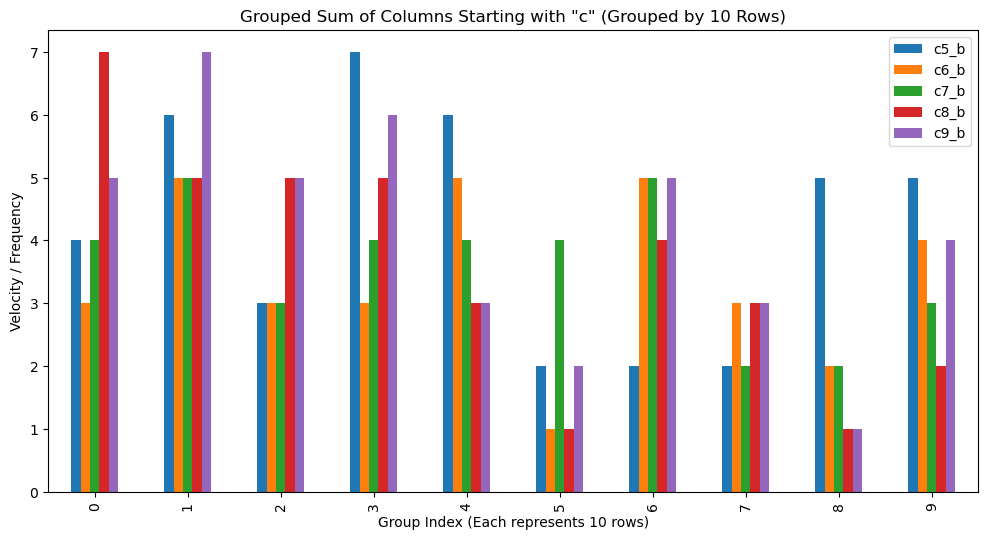

In [28]:
# Plot the result as a bar chart
grouped_sum.iloc[0:10].plot(kind="bar", figsize=(12, 6))

# Add titles and labels
plt.title('Grouped Sum of Columns Starting with "c" (Grouped by 10 Rows)')
plt.xlabel("Group Index/Timeperiods (Each represents 10 timepoints)")
plt.ylabel("Velocity / Frequency")

# Show the plot
plt.show()
# moving bar, one bar on another

In [32]:
grouped_sum.head()

,n0,n1,n2,n3,n4
0,4.811688,4.934748,4.686984,4.187793,5.079172
1,4.905447,5.114118,4.738835,5.000834,5.836114
2,5.152365,4.736618,4.614706,4.290358,4.861821
3,5.062821,4.518815,4.523004,4.624318,5.135941
4,4.825905,5.245837,4.846705,5.287776,6.111226


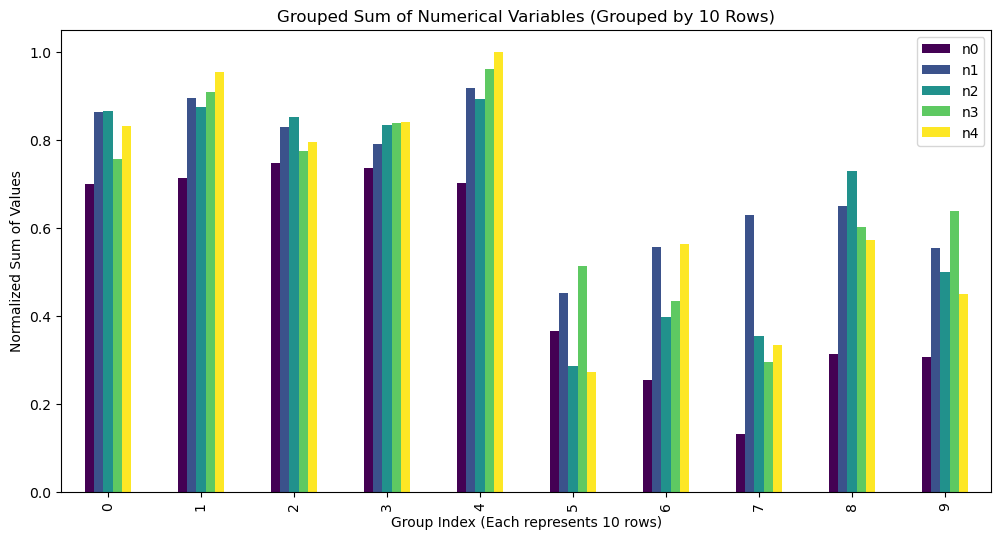

In [31]:
# Filter out numerical columns (you can adjust this condition as needed)
X_df_encoded_m_num = X_df_encoded_m.filter(regex="^n")

# Create a grouping key based on row indices divided by 10
grouped = X_df_encoded_m_num.groupby(X_df_encoded_m_num.index // 10)

# Apply an aggregation function, for example, sum
grouped_sum = grouped.sum()

# Normalize the data so that variables with different ranges can be compared
normalized_grouped_sum = grouped_sum.apply(
    lambda x: (x - x.min()) / (x.max() - x.min()), axis=0
)

# Plot the result as a bar chart
normalized_grouped_sum.iloc[:10].plot(kind="bar", figsize=(12, 6), colormap="viridis")

# Add titles and labels
plt.title("Grouped Sum of Numerical Variables (Grouped by 10 Rows)")
plt.xlabel("Group Index (Each represents 10 rows)")
plt.ylabel("Normalized Sum of Values")

# Show the plot
plt.show()

In [37]:
# Select the two numerical features
features = ["n0", "n1"]
X_df_encoded_m_num = X_df_encoded_m[features]

# Create a grouping key based on row indices divided by 10
X_df_encoded_m_num["Group"] = X_df_encoded_m_num.index // 10
X_df_encoded_m_num.head()

,n0,n1,Group
0,0.530356,0.598345,0
1,0.672618,0.423329,0
2,0.567192,0.576429,0
3,0.474236,0.566046,0
4,0.363202,0.554642,0


In [48]:
X_df_encoded_m_num.head()

,n0,n1,Group
0,0.530356,0.598345,0
1,0.672618,0.423329,0
2,0.567192,0.576429,0
3,0.474236,0.566046,0
4,0.363202,0.554642,0


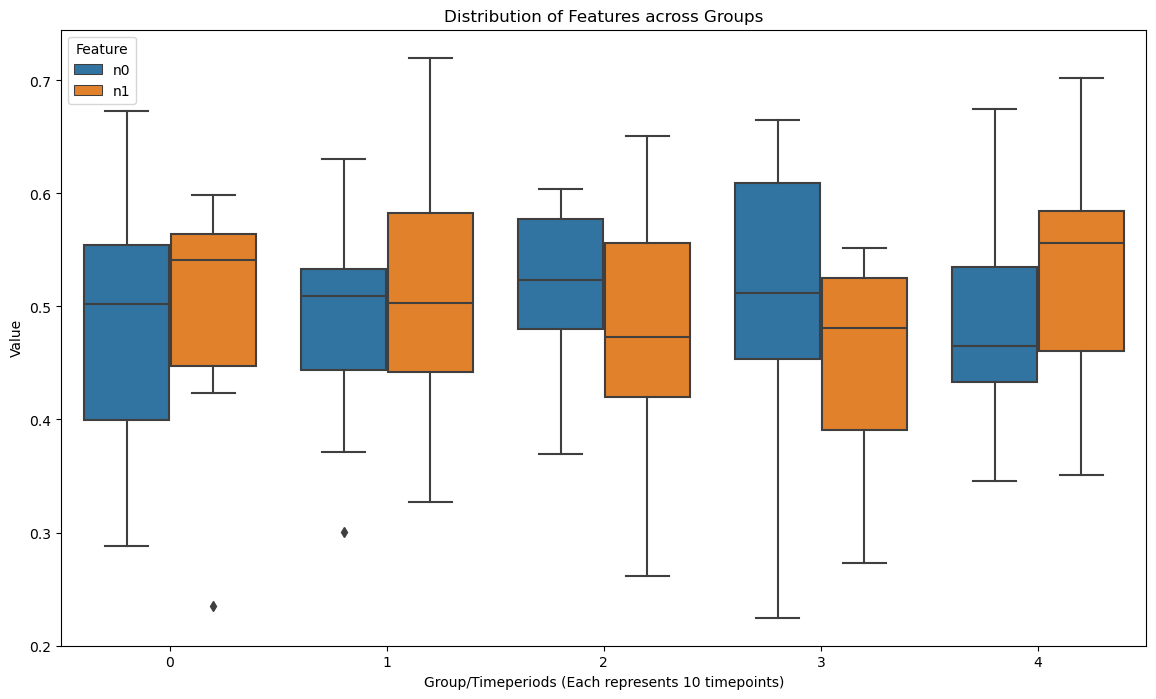

In [51]:
# Select the two numerical features
features = ["n0", "n1"]
X_df_encoded_m_num = X_df_encoded_m[features]

# Create a grouping key based on row indices divided by 10
X_df_encoded_m_num["Group"] = X_df_encoded_m_num.index // 10

# Melt the DataFrame to a long format
melted_df = pd.melt(
    X_df_encoded_m_num,
    id_vars="Group",
    value_vars=features,
    var_name="Feature",
    value_name="Value",
)

melted_df_first_40 = melted_df[melted_df["Group"] < 5]

# Plotting the distributions using box plots
plt.figure(figsize=(14, 8))

sns.boxplot(x="Group", y="Value", hue="Feature", data=melted_df_first_40)
plt.title("Distribution of Features across Groups")
plt.xlabel("Group/Timeperiods (Each represents 10 timepoints)")
plt.ylabel("Value")
plt.legend(title="Feature")

# Show the plot
plt.show()

In [ ]:
# Define the time period
time_period = 10


# Function to plot velocity for each time period
def plot_velocity(df, time_period):
    num_rows = df.shape[0]
    num_periods = int(np.ceil(num_rows / time_period))

    for period in range(num_periods):
        start_idx = period * time_period
        end_idx = min((period + 1) * time_period, num_rows)

        df_period = df.iloc[start_idx:end_idx]

        # Plot histogram/bar plot for each feature in the time period
        df_period.plot(
            kind="bar", subplots=True, layout=(-1, 3), figsize=(15, 10), sharex=True
        )
        plt.suptitle(f"Feature Values from Row {start_idx} to {end_idx-1}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


# Call the function to plot velocity
plot_velocity(X_df_encoded_m, time_period)

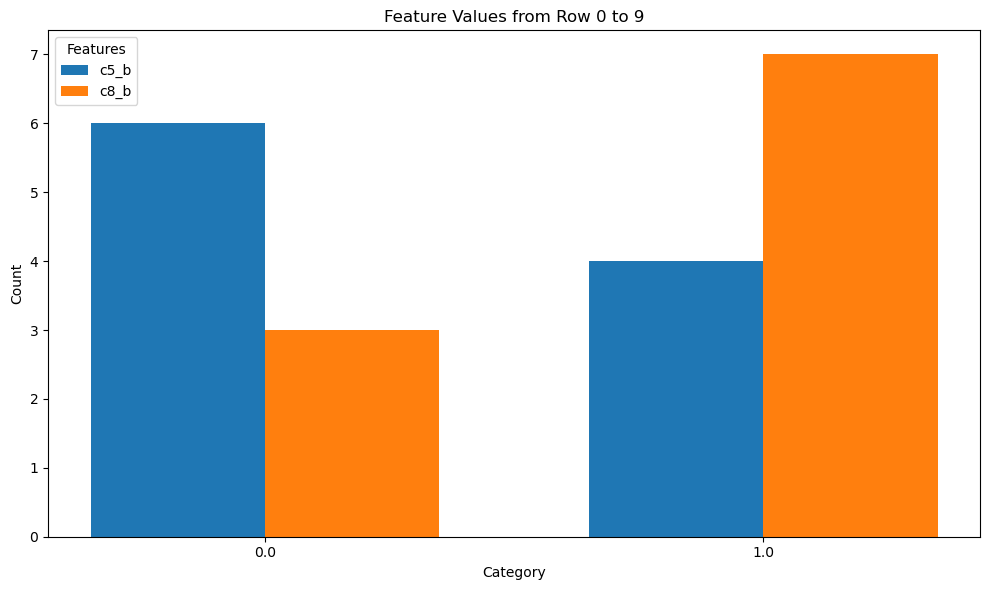

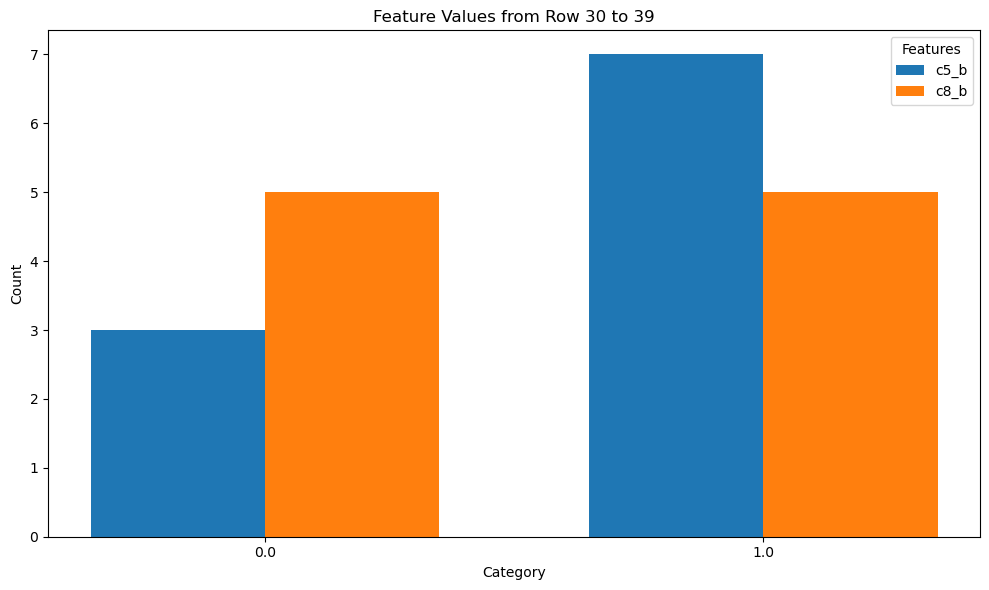

In [14]:
# Function to plot velocity for each time period
def plot_velocity(df, cat_features, time_period=10, periods=None):
    num_rows = df.shape[0]
    num_periods = int(np.ceil(num_rows / time_period))

    if periods is None:
        periods = range(num_periods)

    for period in periods:
        start_idx = period * time_period
        end_idx = min((period + 1) * time_period, num_rows)

        df_period = df.iloc[start_idx:end_idx]

        # Plot bar chart for each pair of categorical features in the time period
        fig, ax = plt.subplots(figsize=(10, 6))
        width = 0.35  # width of bars

        for i, feature in enumerate(cat_features):
            value_counts = df_period[feature].value_counts().sort_index()
            positions = np.arange(len(value_counts)) + (i * width)
            ax.bar(positions, value_counts, width, label=feature)

        ax.set_xticks(np.arange(len(value_counts)) + width / 2)
        ax.set_xticklabels(value_counts.index)
        ax.set_xlabel("Category")
        ax.set_ylabel("Count")
        ax.set_title(f"Feature Values from Row {start_idx} to {end_idx-1}")
        ax.legend(title="Features")
        plt.tight_layout()
        plt.show()


# Call the function to plot velocity for specified time periods
categorical_features = ["c5_b", "c8_b"]  # Replace with your actual categorical features
time_periods_to_visualize = [0, 3]  # Replace with desired time periods to visualize
plot_velocity(
    X_df_encoded_m,
    categorical_features,
    time_period=10,
    periods=time_periods_to_visualize,
)